In [1]:
%matplotlib inline
%load_ext Cython

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pyarrow as pa
from pyarrow import csv
import time

from tqdm import tqdm
from scipy.special import erfc

from scipy.optimize import curve_fit
from scipy import stats
from scipy.special import gamma
from scipy.misc import derivative

import boost_histogram as bh

from nicks_plot_utils import Hist1D, Hist2D


import warnings
warnings.filterwarnings('ignore')


from lmfit.models import *
from lmfit import Model

import inspect

COLOR_BLUE='#348ABD'
COLOR_RED='#A60628'


In [2]:
plt.style.use('fast')
# plt.rcParams['axes.grid'] = True
plt.rcParams['axes.formatter.limits'] = (-3,3)
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size']= 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.rcParams.update({'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsmath}'})

def plot2D(ax, hist, density=False, colorbar=True, cmap='viridis', label=None):
    
    if density:
        # Compute the areas of each bin
        areas = functools.reduce(operator.mul, hist.axes.widths)
        # Compute the density
        density = hist.view() / hist.sum() / areas
        density = np.where(density == 0, np.nan, density)
    else:
        density = hist.view()
        density = np.where(density == 0, np.nan, density)

    pc = ax.pcolormesh(*hist.axes.edges.T, density.T, cmap=cmap)
    
    ax.set_xlabel(hist.axes[0].metadata)
    ax.set_ylabel(hist.axes[1].metadata)
    if colorbar:
        plt.gcf().colorbar(pc, ax=ax, aspect=30)
    return pc

def hist_to_xy(hist):
    x = (hist.axes[0].edges[:-1]+hist.axes[0].edges[1:])/2.0
    y = hist.view()/np.max(hist.view())
    return (x, y)

def plot1D(ax, h, color="", errorbar=True, filled=False, alpha=0.6, lparams={}, fparams={}, bin_edges="", density=True):
    '''
    Function to plot 1D histograms.
    * Uses pylab.step. Gets passed:
       -- bin-edges, minus the last edge in order to match value dimensions.
       -- the count-value of each bin.
    * Color can be specified, or function simply uses the next item in colormap
    * To match a more typical histogram aesthetic, a vertical line is drawn at 
      either end of the step plot.
    * By default, the area under the step-plot is filled.  Can be set False.
    * Can pass any **kwarg dict via lparams/fparams for line/fill respectively.
    '''
    st = None
    if not color:
        color = next(ax._get_lines.prop_cycler)['color']

    if bin_edges == 'left':
        x = h.axes[0].edges[:-1]
    elif bin_edges == 'right':
        x = h.axes[0].edges[1:]
    else:
        x = (h.axes[0].edges[:-1]+h.axes[0].edges[1:])/2.0
        
    if density:
        y = h.view()/np.max(h.view())
        ys = h/np.max(h)
    else:
        y = h.view()
        ys = h
    
    #
    if errorbar:
        st = ax.errorbar(x, y, yerr=stats.sem(y), fmt='.', alpha=alpha, color=color)
    if filled:
        st = ax.fill_between(x, 0, ys,
            alpha=alpha, 
            step='post', 
            color = color,
            **fparams
        )
        
    if st is None:
        st = ax.step(x, y, where='post', color=color,alpha=alpha, **lparams)
    ax.set_xlabel(hist.axes[0].metadata)
        
    return st


In [3]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
#cdef float E0 = 4.8056
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3

@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

@np.vectorize
def calc_wq2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float q2 = temp2
    
    temp_px += p_targ_px
    temp_py += p_targ_py
    temp_pz += p_targ_pz
    temp_E += p_targ_E
    
    temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float w = sqrt(-temp2)
    
    return w, q2


In [4]:
all_data = pd.read_csv("/Users/tylern/Data/fid_cuts.csv")

# %time all_data['w'] = calc_W(all_data.e_p,all_data.e_theta,all_data.e_phi)
# %time all_data['q2'] = calc_q2(all_data.e_p,all_data.e_theta,all_data.e_phi)

%time all_data['w'], all_data['q2'] = calc_wq2(all_data.e_p,all_data.e_theta,all_data.e_phi)

all_data['mom_bin'] = pd.cut(all_data.e_p, [0, 0.5, 1, 1.5, 2, 4, 5])


all_data.head()

CPU times: user 40.7 s, sys: 1min 3s, total: 1min 43s
Wall time: 2min 19s


,sector,e_p,e_theta,e_phi,theta,phi,x,y,type,w,q2,mom_bin
0,3,2.423116,0.320990,-0.386556,0.320990,5.896629,55.282055,-10.660372,other,2.044667,1.192408,"(2.0, 4.0]"
1,2,2.274206,0.357712,0.630286,0.357712,0.630286,72.087662,-8.844837,other,2.065323,1.386950,"(2.0, 4.0]"
2,1,1.986050,0.348010,1.549316,0.348010,1.549316,52.851906,1.477432,other,2.246372,1.147058,"(1.5, 2.0]"
3,4,1.632484,0.395078,-1.635899,0.395078,4.647286,64.732491,4.627306,other,2.375948,1.211596,"(1.5, 2.0]"
4,4,2.294030,0.478871,-1.302595,0.478871,4.980591,129.758835,-34.754814,other,1.768953,2.486113,"(2.0, 4.0]"


In [5]:
fid_data = all_data[all_data.e_p > 1.0] #[all_data.type == "channel"]
print(pd.unique(fid_data.mom_bin))
#fid_data = all_data[all_data.type == "other"]
#fid_data = all_data.copy()

[(2.0, 4.0], (1.5, 2.0], (1.0, 1.5], (4.0, 5.0], NaN]
Categories (4, interval[float64]): [(1.0, 1.5] < (1.5, 2.0] < (2.0, 4.0] < (4.0, 5.0]]


58915662


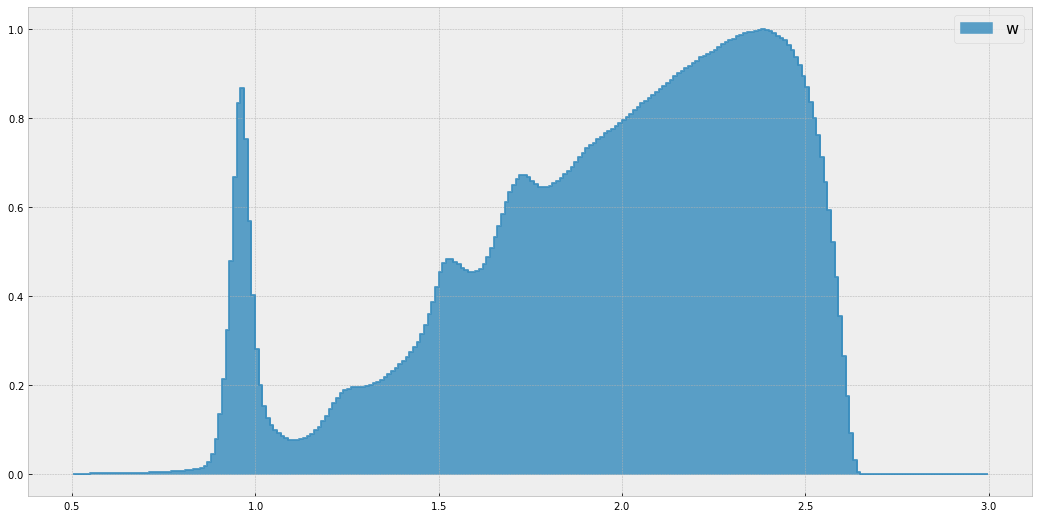

In [6]:
testHist = Hist1D(xrange=[0.5,3.0],bins=250)

testHist.fill(fid_data.w[fid_data.type == "other"])

fig, ax = plt.subplots(figsize=[18,9])
testHist.histogram(filled=True)

# 155537
print(len(fid_data['w']))

(1.0, 1.5]
(1.5, 2.0]
(2.0, 4.0]
(4.0, 5.0]
nan


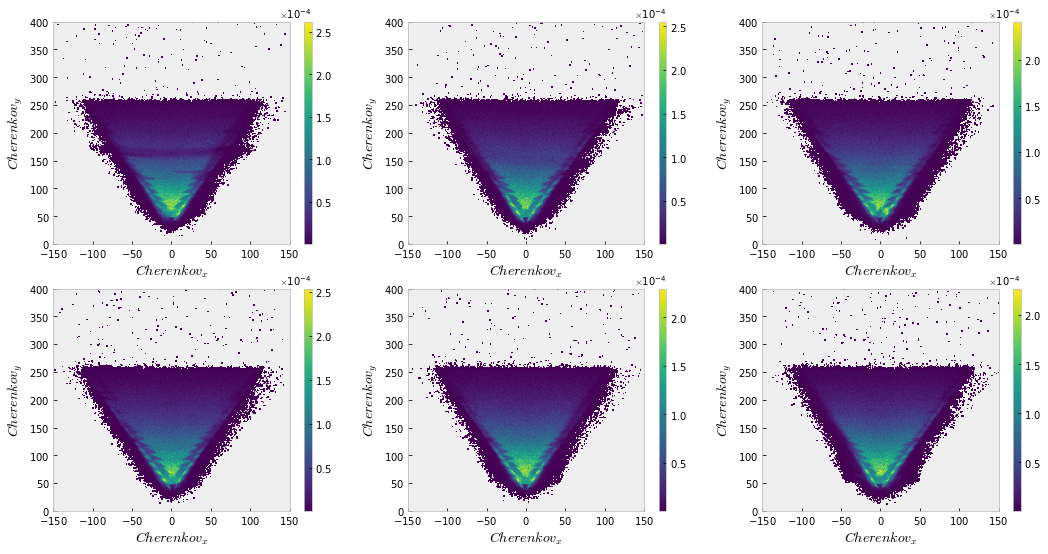

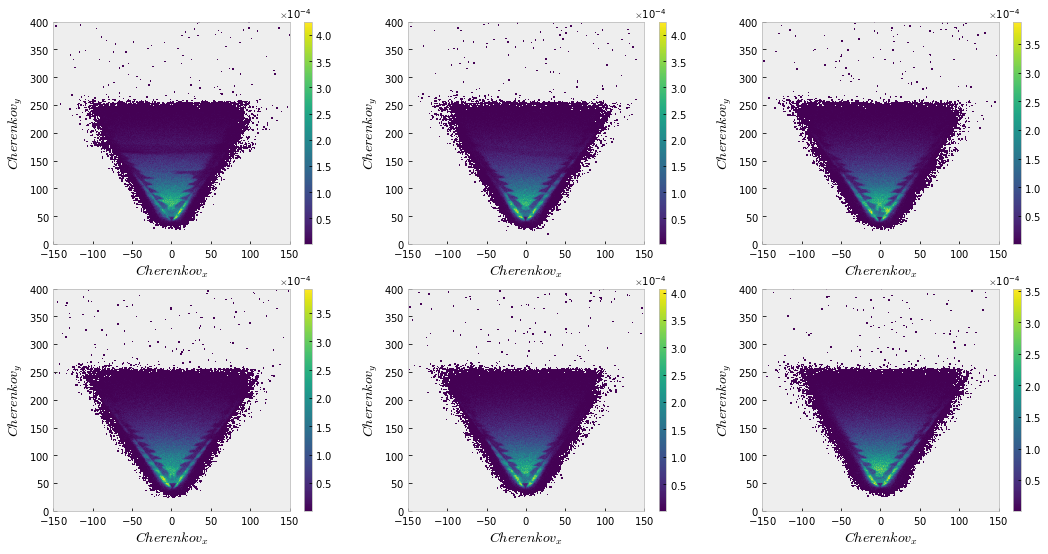

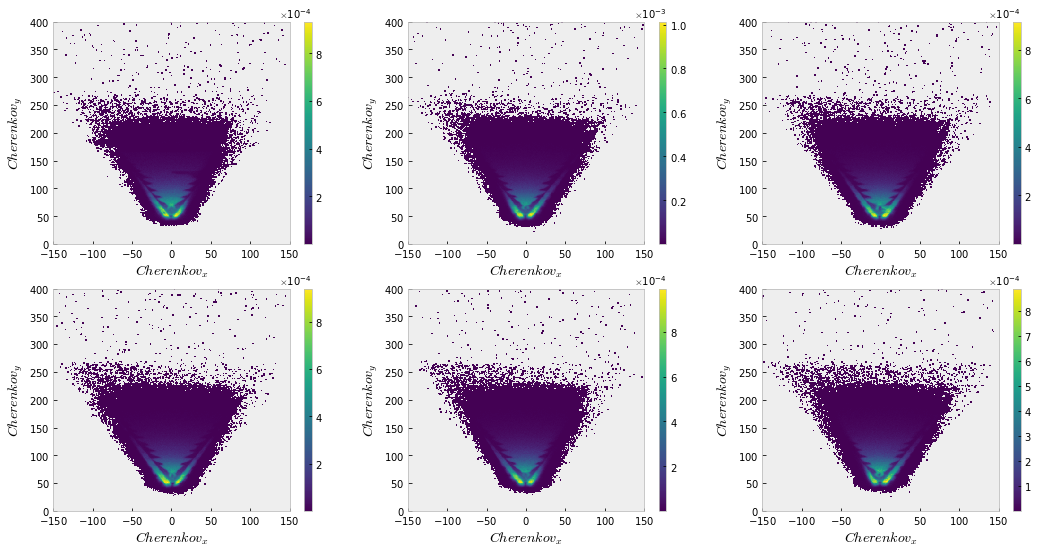

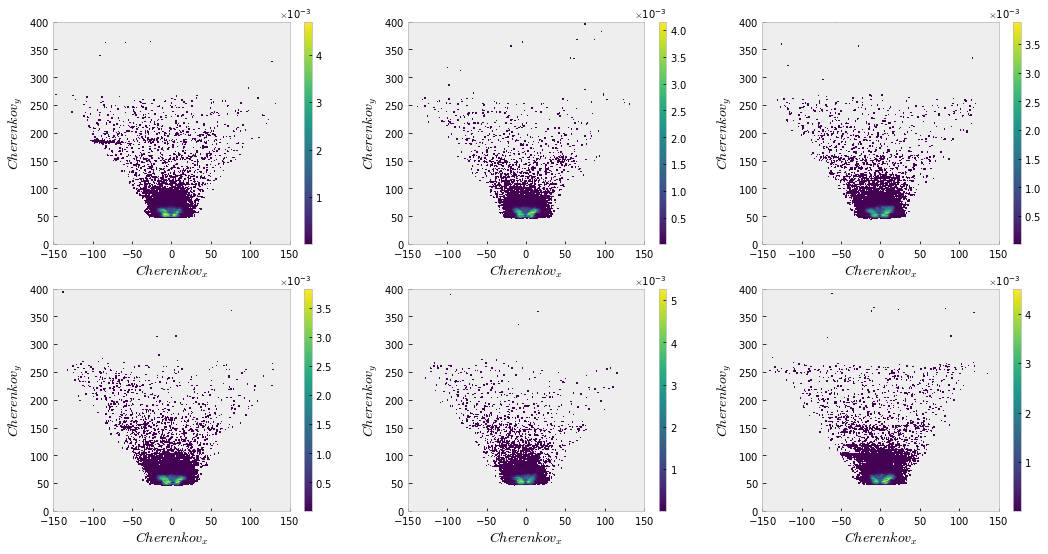

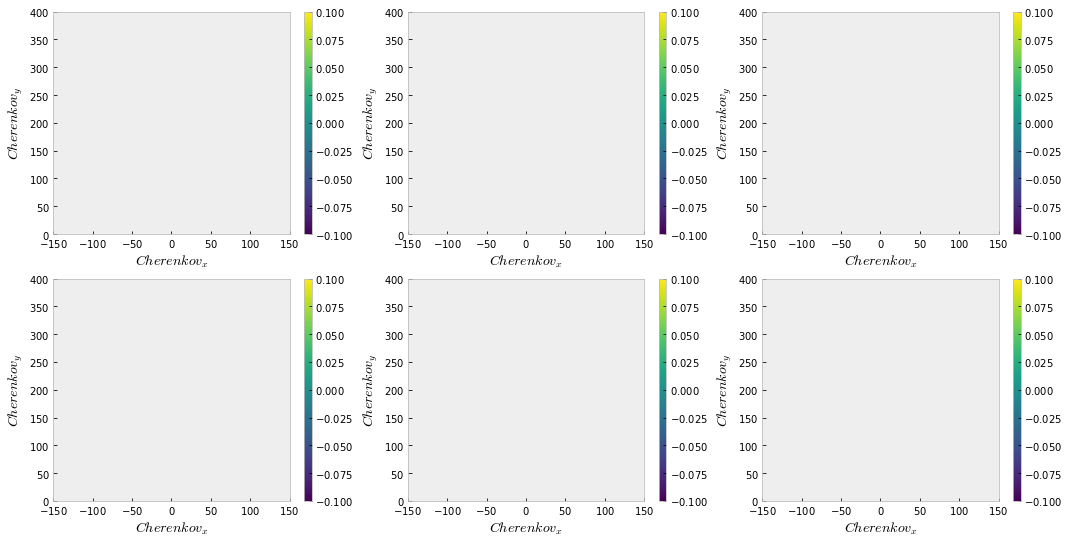

In [7]:
mom_bins = pd.Index.sort_values(pd.unique(fid_data.mom_bin))
for mom in mom_bins:
    print(mom)
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[18,9])
    for sec in range(1,7):
        data = fid_data[(fid_data.sector == sec) & (fid_data.mom_bin == mom)]
        hist = Hist2D(data.y, data.x, xbins=500, xrange=[-150, 150], xname="$Cherenkov_x$", ybins=500, yrange=[0, 400], yname="$Cherenkov_y$")
        hist.plot(ax[sec%2,sec%3], zeros=False)

    fig.show()



In [8]:
def genNormal(x, alpha, beta, cen, amp):
    frac = (beta / (2 * alpha * gamma(1 / beta)))
    expo = np.power(np.abs(x - cen) / alpha, beta)
    func = amp * frac * np.exp(-expo)

    return func

def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))


def getEdges(func, results, xs):
    der = np.gradient(results.eval(x=xs))
    return xs[np.argmax(der)], xs[np.argmin(der)]
    
    

def fit_slice(hist, ax=None):
    x,y = hist_to_xy(hist)

    try:
        func = genNormal
        gmodel = Model(genNormal)
        result = gmodel.fit(y, x=x, alpha=1, beta=1, cen=1, amp=1, nan_policy='omit')
    except ValueError:
        func = gaussian
        gmodel = Model(gaussian)
        result = gmodel.fit(y, x=x, amp=5, cen=0, wid=1)
        
    
    xs = np.linspace(np.min(x),np.max(x),2000)
    ys = result.eval(x=xs)
    left, right = getEdges(func, result, xs)
    
    if ax is not None:
        color = next(ax._get_lines.prop_cycler)['color']
        ax.plot(xs,ys,color=color)
        plt.axvline(left, color=color)
        plt.axvline(right, color=color)
    
    return (left, right)
    




In [9]:
def FitSlices(hist, step_length=10):
    #fig, ax = plt.subplots(figsize=[18,9])

    slice_data = []

    for step in np.arange(0, 300, step_length):
        hist1d = hist[:, bh.loc(step) : bh.loc(step+step_length):bh.sum]
        if hist1d.sum() < 500:
            continue
        #plot1D(ax, hist1d, density=True, alpha=0.3)

        left, right = fit_slice(hist1d, ax=None)

        slice_data.append({'step': step,
                          'left': left,
                          'right':right})


    #plt.show()

    slice_df = pd.DataFrame(slice_data)
    slice_df.head()
    
    return slice_df

2.3059946910025637
52.58368342468228
2.153909463129888
54.12908375398084
2.116181306002975
60.52382351697911
2.2728176319748465
60.45376898396252
2.4343363402751064
47.12798055808955
2.46126865776798
48.845155179894554


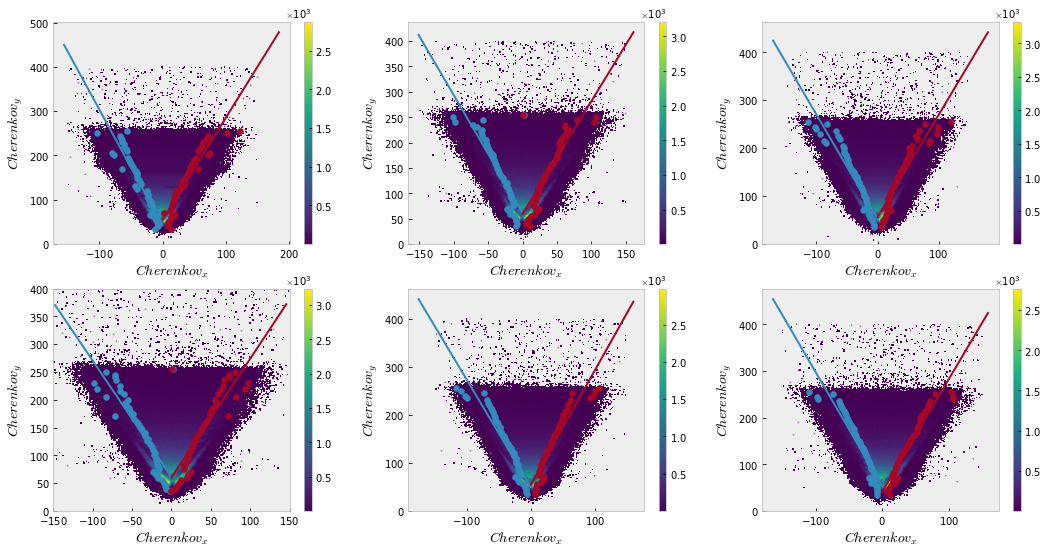

In [63]:
def points_on_2D(ax, data):
    ax.scatter(data.left,data.step)
    ax.scatter(data.right,data.step)
    
    xs = np.linspace(np.min(data.left)*1.5, 0, 200)
    model = LinearModel()
    left = model.fit(data.step, x=data.left)
    ax.plot(xs, left.eval(x=xs))
    
    xs = np.linspace(0, np.max(data.right)*1.5, 200)
    model = LinearModel()
    right = model.fit(data.step, x=data.right)
    ax.plot(xs, right.eval(x=xs))
    
    return left, right
    
    


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[18,9])
for sec in range(1,7):
    data = fid_data[fid_data.sector == sec]
    hist = bh.Histogram(
        bh.axis.Regular(500, -150, 150, metadata="$Cherenkov_x$"), 
        bh.axis.Regular(500, 0, 400, metadata="$Cherenkov_y$")
    )

    hist.fill(data.y, data.x)
    
    plot2D(ax[sec%2,sec%3],hist)
    slice_df = FitSlices(hist, step_length=5)
    
    l,r = points_on_2D(ax[sec%2,sec%3], slice_df)
    print( (-l.params['slope']+r.params['slope'])/2  )
    print( (l.params['intercept']+r.params['intercept'])/2 )

fig.show()



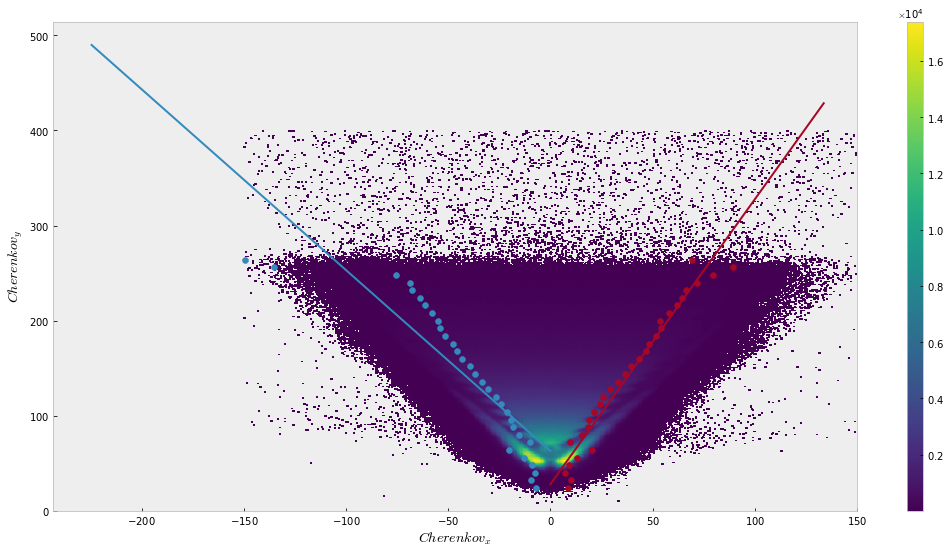

In [11]:
fig, ax = plt.subplots(figsize=[18,9])

hist = bh.Histogram(
    bh.axis.Regular(500, -150, 150, metadata="$Cherenkov_x$"), 
    bh.axis.Regular(500, 0, 400, metadata="$Cherenkov_y$")
)

hist.fill(fid_data.y, fid_data.x)

plot2D(ax,hist)
slice_df = FitSlices(hist, step_length=8)
left_fit, right_fit = points_on_2D(ax, slice_df)

fig.show()

In [12]:
def cut(x, slope, intercept):
    return slope * x + intercept

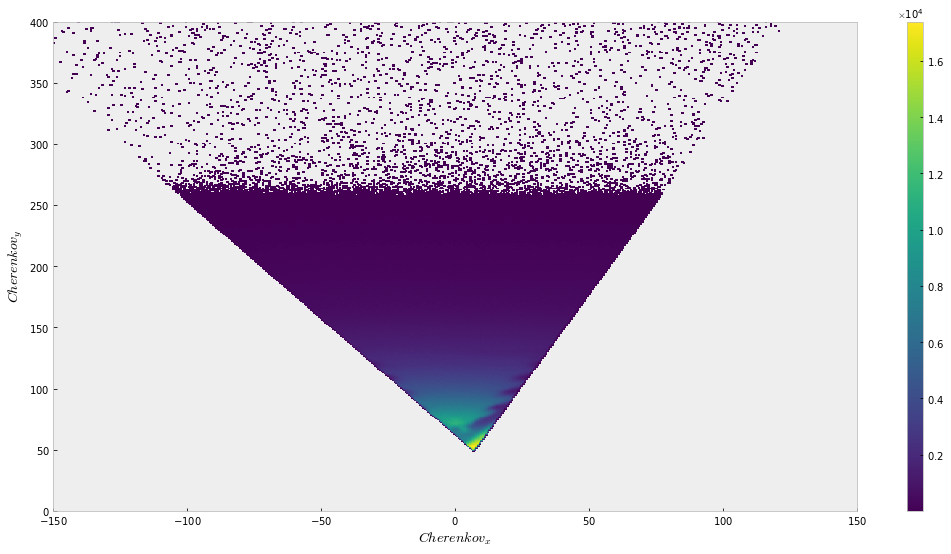

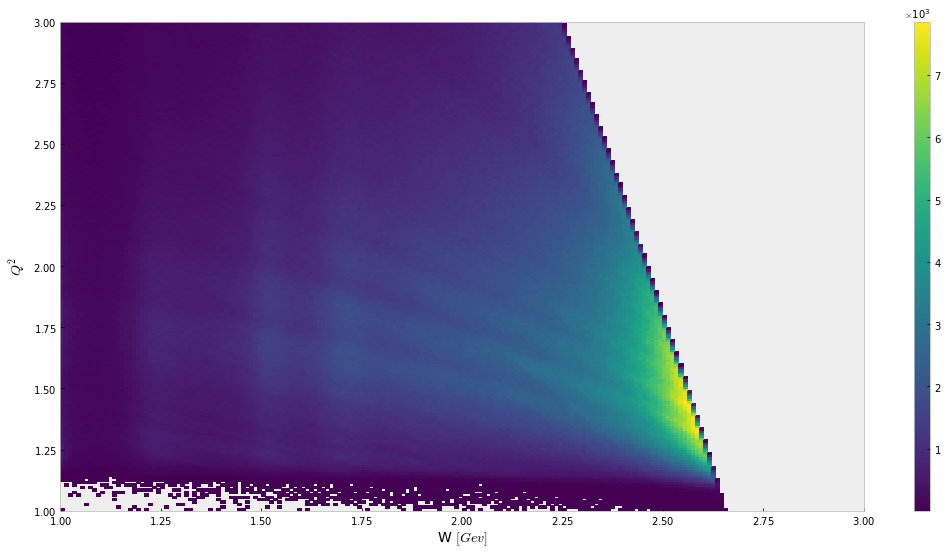

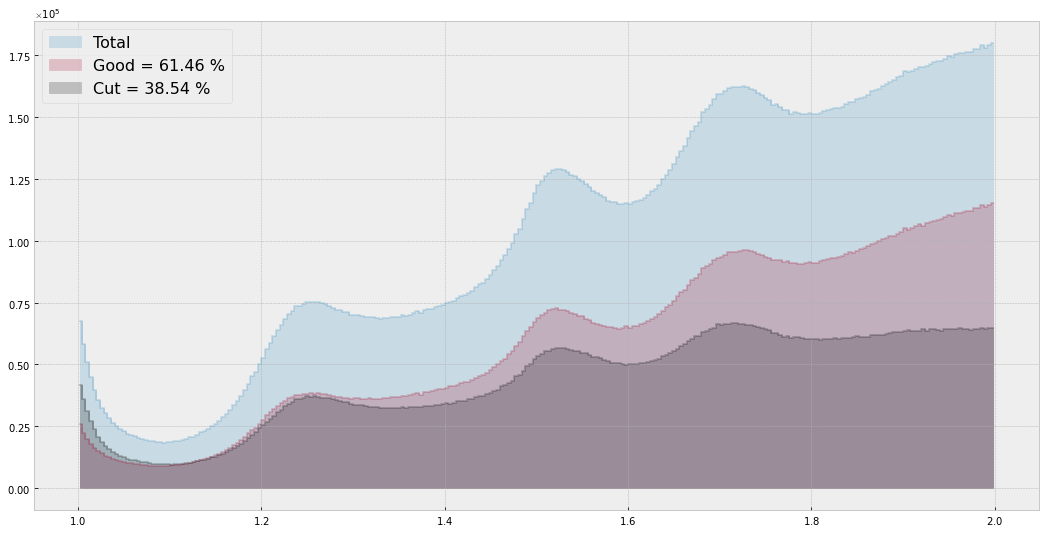

In [13]:
cut_mask = (fid_data.x > cut(fid_data.y, **left_fit.params)) & (fid_data.x > cut(fid_data.y, **right_fit.params))

fig, ax = plt.subplots(figsize=[18,9])
hist = bh.Histogram(
        bh.axis.Regular(500, -150, 150, metadata="$Cherenkov_x$"), 
        bh.axis.Regular(500, 0, 400, metadata="$Cherenkov_y$")
    )

hist.fill(fid_data[cut_mask].y, fid_data[cut_mask].x)
plot2D(ax,hist)
plt.show()

fig, ax = plt.subplots(figsize=[18,9])
hist = bh.Histogram(
        bh.axis.Regular(200, 1.0, 3.0, metadata="W $[Gev]$"), 
        bh.axis.Regular(200, 1.0, 3.0, metadata="$Q^2$")
    )

hist.fill(fid_data[cut_mask].w, fid_data[cut_mask].q2)



per_cut = 100*np.sum(~cut_mask)/fid_data.w.to_numpy().shape[0]
per_save = 100*np.sum(cut_mask)/fid_data.w.to_numpy().shape[0]

plot2D(ax,hist)
plt.show()

fig, ax = plt.subplots(figsize=[18,9])
Hist1D(data=fid_data.w, bins=250, xrange=[1.0,2.0]).histogram(filled=True, alpha=0.2, density=False, label="Total")
Hist1D(data=fid_data[cut_mask].w, bins=250, xrange=[1.0,2.0]).histogram(filled=True, alpha=0.2, density=False, label=f"Good = {per_save:0.2f} %")
Hist1D(data=fid_data[~cut_mask].w, bins=250, xrange=[1.0,2.0]).histogram(filled=True, alpha=0.2, density=False, label=f"Cut = {per_cut:0.2f} %", color='k')

In [14]:
print("Left")
left_fit.params.pretty_print()
print()
print("Right")
right_fit.params.pretty_print()

Left
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept     63.07     -inf      inf    10.14     True     None     None
slope        -1.901     -inf      inf   0.1877     True     None     None

Right
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept     28.15     -inf      inf    5.239     True     None     None
slope         2.993     -inf      inf   0.1158     True     None     None


Number = 1,069,699
Number = 508,956


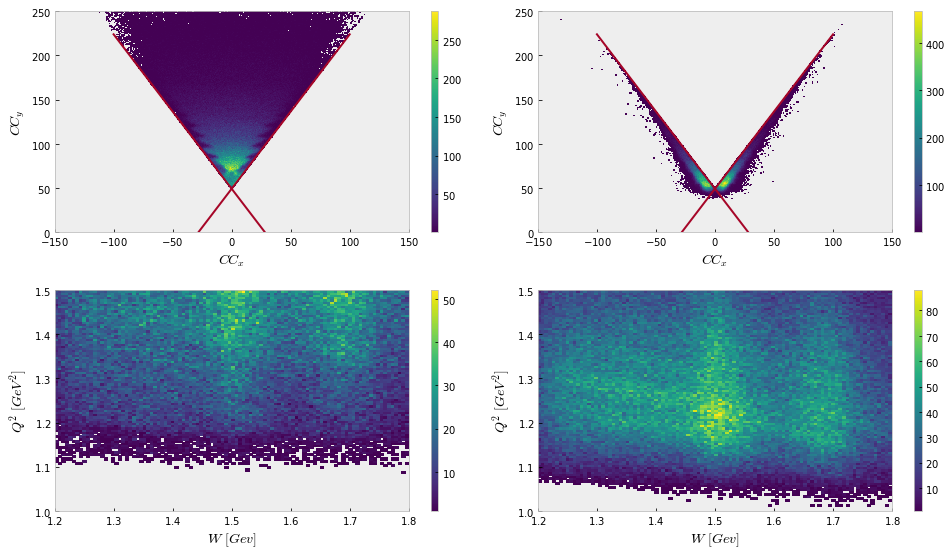

In [15]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=[14,8])
for i, cut_mask in enumerate([cuts, ~cuts]):
    do_cuts = (cut_mask) & (fid_data.type == "channel")
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[0,i],hist)
    xs = np.linspace(-50,100, 250)
    ax[0, i].set_ylim(0, 250)
    ax[0, i].plot(xs,line(xs, slope, intercept), c=COLOR_RED)
    ax[0, i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED)
    #plt.show()

    #fig, ax = plt.subplots(figsize=[18,9])
    hist = bh.Histogram(
            bh.axis.Regular(100, 1.2, 1.8, metadata="$W~[Gev]$"), 
            bh.axis.Regular(100, 1.0, 1.5, metadata="$Q^2~[GeV^2]$")
        )

    hist.fill(fid_data[do_cuts].w, fid_data[do_cuts].q2)
    plot2D(ax[1,i], hist, label=f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    
#plt.legend()
plt.tight_layout()

Number = 2,303,126
Number = 1,167,454


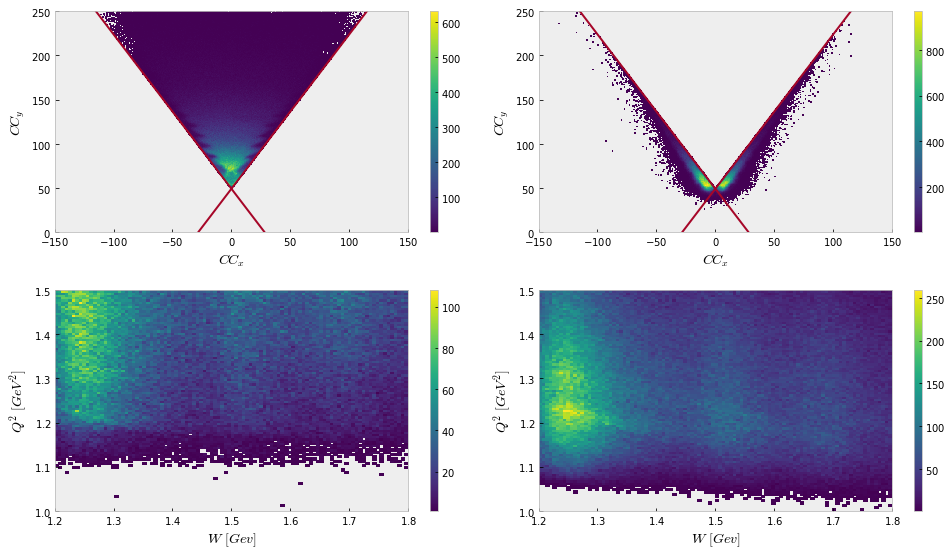

In [16]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=[14,8])
for i, cut_mask in enumerate([cuts, ~cuts]):
    do_cuts = (cut_mask) & (fid_data.type == "PPi0")
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[0,i],hist)
    xs = np.linspace(-50, 120, 250)
    ax[0, i].set_ylim(0, 250)
    ax[0, i].plot(xs,line(xs, slope, intercept), c=COLOR_RED)
    ax[0, i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED)
    #plt.show()

    #fig, ax = plt.subplots(figsize=[18,9])
    hist = bh.Histogram(
            bh.axis.Regular(100, 1.2, 1.8, metadata="$W~[Gev]$"), 
            bh.axis.Regular(100, 1.0, 1.5, metadata="$Q^2~[GeV^2]$")
        )

    hist.fill(fid_data[do_cuts].w, fid_data[do_cuts].q2)
    plot2D(ax[1,i],hist)
    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    # ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.tight_layout()

Number = 38,714,825
Number = 15,151,602


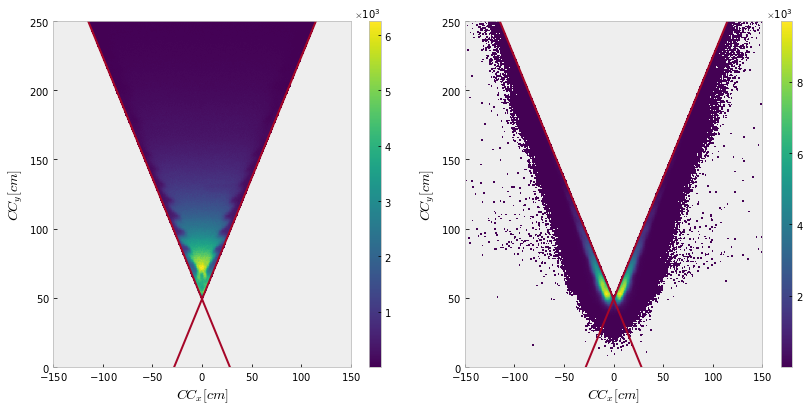

In [24]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12, 6])
for i, cut_mask in enumerate([cuts, ~cuts]):
    do_cuts = (cut_mask) & (fid_data.type == "other")
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y [cm]$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[i],hist)
    xs = np.linspace(-50,120, 250)
    ax[i].set_ylim(0, 250)
    ax[i].plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
    ax[i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)


    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    #ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.tight_layout()

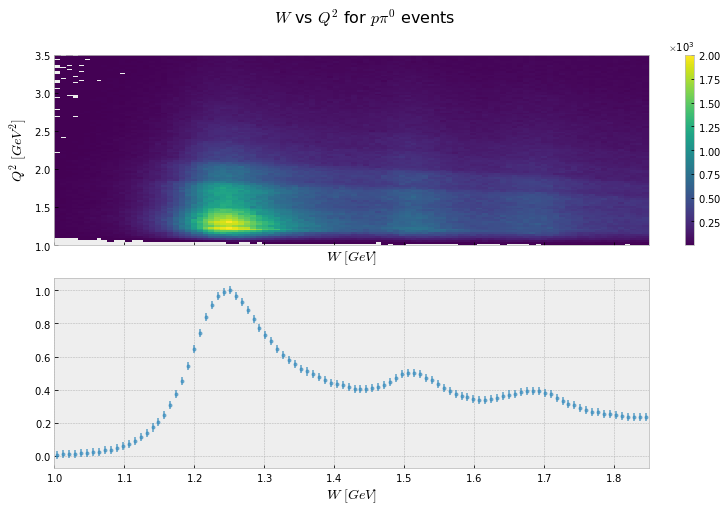

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[10,7], sharex=True, constrained_layout=True)

hist = bh.Histogram(
            bh.axis.Regular(100, 1.0, 1.85, metadata="$W~[GeV]$"), 
            bh.axis.Regular(100, 1.0, 3.5, metadata="$Q^2~[GeV^2]$")
        )

hist.fill(fid_data[fid_data.type == "PPi0"].w, fid_data[fid_data.type == "PPi0"].q2)

plot2D(ax[0], hist)
plot1D(ax[1], hist.project(0))


fig.suptitle('$W$ vs $Q^2$ for $p\pi^{0}$ events', fontsize=16)
plt.show()

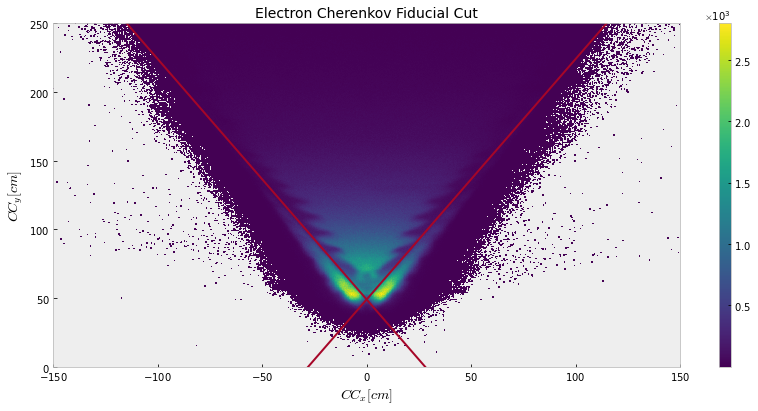

In [36]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(figsize=[12, 6])

hist = bh.Histogram(
            bh.axis.Regular(1000, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(1000, 0, 250, metadata="$CC_y [cm]$")
    )

hist.fill(fid_data.y, fid_data.x)
plot2D(ax,hist)
xs = np.linspace(-50,120, 250)
ax.set_ylim(0, 250)
ax.plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
ax.plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)

plt.title("Electron Cherenkov Fiducial Cut")
plt.tight_layout()

Number = 9,312,177
Number = 10,524,806
Number = 10,281,080
Number = 9,699,312
Number = 9,645,249
Number = 9,453,038


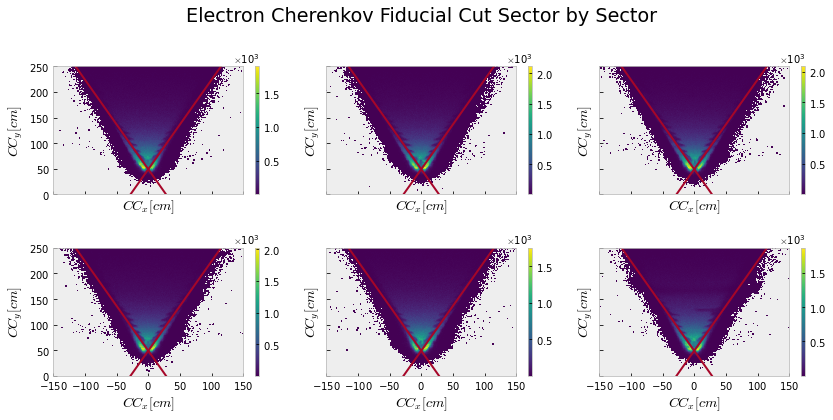

In [41]:
slope = 1.75
intercept = 49

plots = {
        1 : (0,0),
        2 : (0,1),
        3 : (0,2),
        4 : (1,0),
        5 : (1,1),
        6 : (1,2),
       }

def line(xs, slope, intercept):
    return slope*xs + intercept

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 6], sharex=True, sharey=True)
for sec in range(1, 7):
    do_cuts = fid_data.sector == sec
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y [cm]$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[plots[sec][0],plots[sec][1]],hist)
    xs = np.linspace(-50,120, 250)
    ax[plots[sec][0],plots[sec][1]].set_ylim(0, 250)
    ax[plots[sec][0],plots[sec][1]].plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
    ax[plots[sec][0],plots[sec][1]].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)


    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    #ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.suptitle("Electron Cherenkov Fiducial Cut Sector by Sector")
plt.tight_layout()

Number = 9,312,177
Number = 10,524,806
Number = 10,281,080
Number = 9,699,312
Number = 9,645,249
Number = 9,453,038


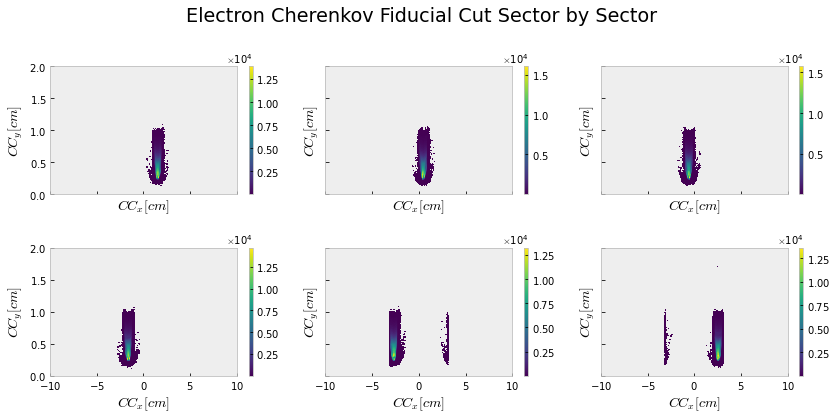

In [45]:
plots = {
        1 : (0,0),
        2 : (0,1),
        3 : (0,2),
        4 : (1,0),
        5 : (1,1),
        6 : (1,2),
       }

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 6], sharex=True, sharey=True)
for sec in range(1, 7):
    do_cuts = fid_data.sector == sec
    hist = bh.Histogram(
            bh.axis.Regular(500, -10, 10, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(500, 0, 2, metadata="$CC_y [cm]$")
        )

    hist.fill(fid_data[do_cuts].e_phi, fid_data[do_cuts].e_theta)
    plot2D(ax[plots[sec][0],plots[sec][1]],hist)


    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    #ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.suptitle("Electron Cherenkov Fiducial Cut Sector by Sector")
plt.tight_layout()

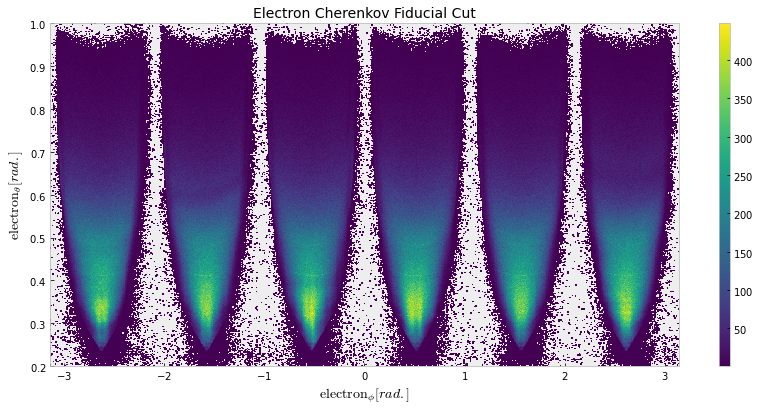

In [55]:
fig, ax = plt.subplots(figsize=[12, 6])

slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

hist = bh.Histogram(
            bh.axis.Regular(1000, -np.pi, np.pi, metadata="$\mathrm{electron}_{\phi} [rad.]$"), 
            bh.axis.Regular(1000, 0.2, 1.0, metadata="$\mathrm{electron}_{\\theta} [rad.]$")
    )

hist.fill(fid_data[cuts].e_phi, fid_data[cuts].e_theta)
plot2D(ax,hist)

plt.title("Electron Cherenkov Fiducial Cut in $$")
plt.tight_layout()